# Symplectic explicit integrators in OrdinaryDiffEq

<ul id="top">
    <li><a href="#Loading-packages-and-functions">Loading packages and functions</a></li>
    <li><a href="#Initial-value-problem:-Hénon-Heiles">Initial value problem: Hénon-Heiles</a></li>
    <li><a href="#IRKNGL-integrations">IRKNGL-integrations</a></li>
    <li><a href="#2nd-order-explicit-symplectic-integrations">2nd order explicit symplectic integrations</a></li>
    <li><a href="#Benchmarks-diagrams">Benchmarks diagrams</a></li>
    <ul>
        <li><a href="#Work-precison-diagrams">Work-precison-diagrams</a></li>
        <li><a href="#Error-in-Energy">Error in Energy</a></li>
        <li><a href="#Error-in-Solution">Error in Solution</a></li>
    </ul>
</ul>

## Loading packages and functions

In [1]:
using LinearAlgebra
using Plots
using OrdinaryDiffEq

PATH_IRKGL="../../../../IRKGaussLegendre.jl-master/IRKGaussLegendre.jl-master/"
include(string(PATH_IRKGL,"src/IRKGaussLegendre.jl"))
using .IRKGaussLegendre  ## bertsio lokala exekutatzeko  

### IRKGL functions

In [2]:
function run_many_IRKGL(ddt0, tspan,u0, parms, HAM;simdB=true)

    nruns=1
    
    u0_B=BigFloat.(u0)
    parms_B=BigFloat.(parms)
    
    cpus=similar(ddt0)
    iters=similar(ddt0)
    retcodes=[true for k in ddt0]
    MaxΔHglobal=[0. for i in ddt0]
    MaxΔHlocal=[0. for i in ddt0]
    
    sols=Array{IRKGaussLegendre.ODESolution}(undef,length(ddt0))
    prob = ODEProblem{true,SciMLBase.FullSpecialize}(HenonHeilesODE!, u0, tspan)
    H0=HAM(u0_B)
    
    for i in 1:length(ddt0)
        
        print(",",ddt0[i])    
        dt0=ddt0[i]
        
        # save_everystep=true
        m0=1
        alg=IRKGL16(simd=simdB, second_order_ode=true, mstep=m0)
        sols[i]=solve(prob,alg,dt=dt0,adaptive=false)
        if sols[i].retcode==ReturnCode.Success
           iters[i]=sols[i].stats.nfpiter
        else
           retcodes[i]=false
           iters[i]=Inf
        end

        m0 = max(1,div(Int64(ceil((tF-t0)/ddt0[i])),1000))      
        H = [HAM(BigFloat.(u)) for u in sols[i].u]
        ΔH0 = @. Float64(abs(H/H0-1))
        H_lerr = @. Float64(abs((H[2:end] / H[1:end-1]) - 1))
        MaxΔHglobal[i]=maximum(ΔH0)
        MaxΔHlocal[i]=maximum(H_lerr)
 
        # save_everystep=false
        solx=solve(prob,alg,dt=dt0,adaptive=false,save_everystep = false)
        if solx.retcode==ReturnCode.Success
           cpus[i]=0.
           for k in 1:nruns
               cpus[i]+=@elapsed solve(prob,alg,dt=dt0,adaptive=false, save_everystep = false)
           end
           cpus[i]=cpus[i]/nruns
        else
           cpus[i]=Inf
        end
        
    end

    return sols,retcodes,iters,cpus,MaxΔHglobal,MaxΔHlocal

end    


function plots_IRKGL(title,ddt0, u0, parms, HAM, sols,iters,cpus,MaxΔH)
    
    u0_B=BigFloat.(u0)
    parms_B=BigFloat.(parms)
    
    H0=HAM(u0_B)
    MaxΔH=[0. for i in ddt0]

    pl1=plot(ddt0,cpus, seriestype=:scatter,label="", 
             title="CPU-time", xlabel="dt", ylabel="CPU");
    pl2=plot(ddt0,iters, seriestype=:scatter, label="",
         title="Iterations", xlabel="dt", ylabel="iter");

    pl3=plot(title="Error in Ham",xlabel="t ", ylabel="log10(H/H0)", 
              yscale=:log10, label="")

     for  i in 1:length(ddt0)
          m0 = max(1,div(Int64(ceil((tF-t0)/ddt0[i])),1000))
          ΔH0 = map(x->HAM(BigFloat.(x)), sols[i].u)./H0.-1 
          pl3=plot!(sols[i].t[2:m0:end],abs.(ΔH0[2:m0:end]), labels="")
     end

     fig=plot(pl1,pl2,pl3, layout=(1,3), size=(950,300),plot_title=title, plot_titlevspan=0.2)
     return fig
    
end

plots_IRKGL (generic function with 1 method)

In [3]:
function run_many_2ndMethod(alg, ddt0, tspan,u0, parms, HAM)

    nruns=1
    
    u0_B=BigFloat.(u0)
    #parms_B=BigFloat.(parms)
    
    
    cpus=similar(ddt0)
    retcodes=[true for k in ddt0]
    MaxΔHglobal=[0. for i in ddt0]
    MaxΔHlocal=[0. for i in ddt0]
    
    sols=Array{OrdinaryDiffEq.ODESolution}(undef,length(ddt0))
    
    prob = SecondOrderODEProblem(HenonHeilesODE2nd!,p0,q0,tspan)
    H0=HAM(u0_B)
    
    
    for i in 1:length(ddt0)
        
        print(",",ddt0[i])    
        dt0=ddt0[i]

        
        # save_everystep=true
        m0=1
        sols[i]=solve(prob,alg,dt=dt0, save_everystep=true, adaptive=false)
      
        if sols[i].retcode==ReturnCode.Success
           retcodes[i]=true
        else
           retcodes[i]=false
        end

        
        T=typeof(u0)
        solu=Array{T}(undef,length(sols[i].u))     
        for k in 1:length(solu)
            solu[k]=zero(u0)
            solu[k][1:2].=sols[i].u[k].x[2]
            solu[k][3:4].=sols[i].u[k].x[1]
        end

       
        m0 = max(1,div(Int64(ceil((tF-t0)/ddt0[i])),1000))      
        H = [HAM(BigFloat.(u)) for u in solu]
        ΔH0 = @. Float64(abs(H/H0-1))
        H_lerr = @. Float64(abs((H[2:end] / H[1:end-1]) - 1))
        MaxΔHglobal[i]=maximum(ΔH0)
        MaxΔHlocal[i]=maximum(H_lerr)
        
        
        # save_everystep=false
        solx=solve(prob,alg,dt=dt0,adaptive=false,save_everystep = false)
        if solx.retcode==ReturnCode.Success
           cpus[i]=0.
           for k in 1:nruns
               cpus[i]+=@elapsed solve(prob,alg,dt=dt0,adaptive=false, save_everystep = false)
           end
           cpus[i]=cpus[i]/nruns
        else
           cpus[i]=Inf
        end
      
  
    end

    return sols,retcodes,cpus,MaxΔHglobal,MaxΔHlocal

    

end 


function plots_2ndMethod(title,ddt0,u0, parms, HAM, sols,cpus,MaxΔH)
    
    H0=HAM(u0_B)
    MaxΔH=[0. for i in ddt0]

    pl1=plot(ddt0,cpus, seriestype=:scatter,label="", 
             title="CPU-time", xlabel="dt", ylabel="CPU");

    pl3=plot(title="Error in Ham",xlabel="t ", ylabel="log10(H/H0)", 
              yscale=:log10, label="")

     for  i in 1:length(ddt0)
        
          T=typeof(u0)
          solu=Array{T}(undef,length(sols[i].u))     
          for k in 1:length(solu)
            solu[k]=zero(u0)
            solu[k][1:2].=sols[i].u[k].x[2]
            solu[k][3:4].=sols[i].u[k].x[1]
          end
        
          m0 = max(1,div(Int64(ceil((tF-t0)/ddt0[i])),1000))
          ΔH0 = map(x->HAM(BigFloat.(x)), solu)./H0.-1 
          pl3=plot!(sols[i].t[2:m0:end],abs.(ΔH0[2:m0:end]), labels="")
     end

     fig=plot(pl1,pl3, layout=(1,2), size=(650,300),plot_title=title, plot_titlevspan=0.2)
     return fig
    
end

plots_2ndMethod (generic function with 1 method)

##### <a href="#top">Hasierara</a>

## Initial value problem: Hénon-Heiles

We consider the Hénon-Heiles model which is Hamiltonian with

\begin{align*}
H(q,p)=\frac{1}{2} (p_1^2+p_2^2)+\frac{1}{2}(q_1^2+q_2^2)+q_1^2q_2-\frac{1}{3}q_2^3
\end{align*}

and the corresponding system

\begin{align*}
& \frac{dq_1}{dt}=p_1, \quad 
\frac{dq_2}{dt}=p_2, \\
& \frac{dp_1}{dt}=-q_1-2q_1q_2, \quad 
 \frac{dp_2}{dt}=-q_2-q_1^2+q_2^2
\end{align*}

In [4]:
PATH_ODES=string(PATH_IRKGL,"ODEProblems/")
include(string(PATH_ODES,"HenonHeiles.jl"));

In [5]:
# Gemetric Numerical Integration 15.page

q0=[0,3/10]
p0=[0, 2/10]

# Non-Chaotic solution H0=1/12

H0=1/12
U0=Potential_U(q0[1],q0[2])
p0[1]=sqrt(2*H0-2*U0-p0[2]^2)
p = []

u0=vcat(q0,p0)
u0_B=BigFloat.(u0)
H0_1=HenonHeliesHam(u0_B)

println("Problem1: non-chaotic solution, H0=",Float32(H0_1))

t0 = 0.
tF = 2*pi*1e4
tspan=(t0,tF)

prob_1 = ODEProblem(HenonHeilesODE!, u0, tspan)
probDyn_1=DynamicalODEProblem(HenonHeilesODEq!,HenonHeilesODEv!,q0,p0,tspan)
prob2nd_1=SecondOrderODEProblem(HenonHeilesODE2nd!,p0,q0,(t0,tF));

Problem1: non-chaotic solution, H0=0.083333336


##### <a href="#top">Back to the top</a>

## IRKNGL integrations

HAM(u0) = 0.08333333333333333
,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0

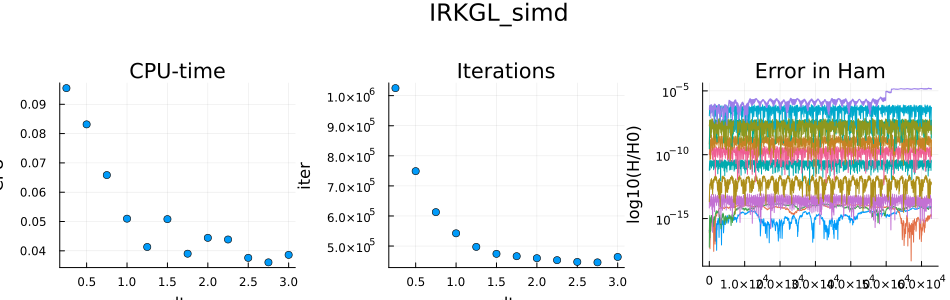

,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0

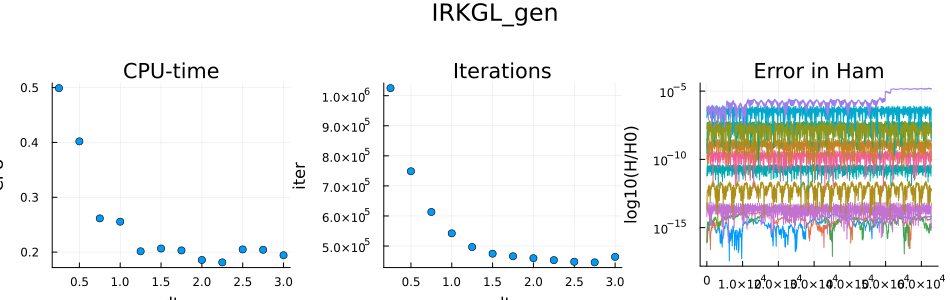

In [6]:
HAM=HenonHeliesHam
@show(HAM(u0))

#ddt0=2*pi*collect(1/24:1/24:1/2)
ddt0=collect(1/4:1/4:3)

sols_simd,retcodes_simd,iters_simd,cpus_simd,MaxΔHglobal_simd,MaxΔHlocal_simd=
run_many_IRKGL(ddt0, tspan, u0, [0.], HAM; simdB=true)
fig=plots_IRKGL("IRKGL_simd",ddt0,u0, [0.],HAM,sols_simd,iters_simd,cpus_simd,MaxΔHlocal_simd)
display(fig)
#
sols_gen,retcodes_gen,iters_gen,cpus_gen, MaxΔHglobal_gen, MaxΔHlocal_gen=
run_many_IRKGL(ddt0, tspan, u0, [0.], HAM; simdB=false)
fig=plots_IRKGL("IRKGL_gen",ddt0,u0, [0.], HAM,sols_gen,iters_gen,cpus_gen,MaxΔHlocal_gen)
display(fig)

In [7]:
[ddt0 retcodes_simd iters_simd cpus_simd MaxΔHlocal_simd]

12×5 Matrix{Float64}:
 0.25  1.0       1.02503e6  0.0955095  3.52383e-16
 0.5   1.0  749044.0        0.0831459  4.09499e-16
 0.75  1.0  612720.0        0.0658438  5.91807e-16
 1.0   1.0  542376.0        0.0509663  3.13653e-14
 1.25  1.0  497225.0        0.0413077  1.26389e-12
 1.5   1.0  474100.0        0.0508115  2.5221e-11
 1.75  1.0  466289.0        0.0390156  3.05756e-10
 2.0   1.0  459654.0        0.0444288  2.56567e-9
 2.25  1.0  453142.0        0.0438617  1.6192e-8
 2.5   1.0  447263.0        0.0376009  8.15254e-8
 2.75  1.0  445773.0        0.0360587  3.40396e-7
 3.0   1.0  463823.0        0.0386164  6.09815e-6

In [8]:
[ddt0 retcodes_gen iters_gen cpus_gen MaxΔHlocal_gen]

12×5 Matrix{Float64}:
 0.25  1.0       1.02507e6  0.499092  3.52817e-16
 0.5   1.0  748567.0        0.401993  4.76586e-16
 0.75  1.0  613189.0        0.261532  7.55381e-16
 1.0   1.0  542224.0        0.255488  3.13596e-14
 1.25  1.0  496622.0        0.201478  1.26397e-12
 1.5   1.0  474419.0        0.206561  2.52209e-11
 1.75  1.0  465849.0        0.203136  3.05756e-10
 2.0   1.0  459563.0        0.185705  2.56567e-9
 2.25  1.0  452933.0        0.1813    1.6192e-8
 2.5   1.0  447739.0        0.204935  8.15254e-8
 2.75  1.0  445592.0        0.204291  3.40396e-7
 3.0   1.0  463919.0        0.194313  6.09815e-6

<a href="#top">Back to the top</a>

## 2nd order explicit symplectic integrations

### VelocityVerlet

HAM(u0) = 0.08333333333333333
,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9

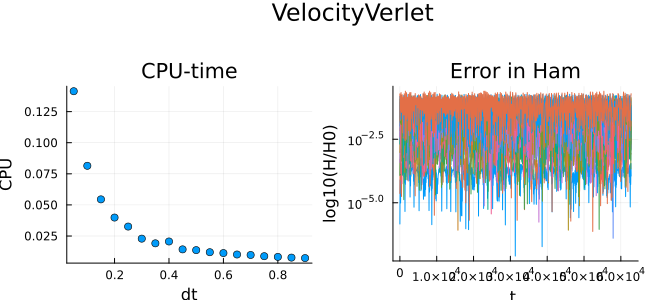

In [9]:
HAM=HenonHeliesHam
@show(HAM(u0))

#ddt0_verlet=collect(1/8:1/8:1.6)/2
ddt0_verlet=collect(1/20:1/20:0.9)
#ddt0_verlet=[1.]

alg=VelocityVerlet()
sols_verlet,retcodes_verlet,cpus_verlet,MaxΔHglobal_verlet,MaxΔHlocal_verlet =
run_many_2ndMethod(alg, ddt0_verlet, tspan, u0, [0.], HAM);

fig=plots_2ndMethod("VelocityVerlet",ddt0_verlet, u0, [0.], HAM,sols_verlet,cpus_verlet,MaxΔHlocal_verlet)
display(fig)

In [10]:
[ddt0_verlet retcodes_verlet  cpus_verlet MaxΔHglobal_verlet MaxΔHlocal_verlet]

18×5 Matrix{Float64}:
 0.05  1.0  0.141405    0.000492929  5.17037e-5
 0.1   1.0  0.0814485   0.0019776    0.000413557
 0.15  1.0  0.0544575   0.00447186   0.0013956
 0.2   1.0  0.039829    0.00800586   0.00330855
 0.25  1.0  0.0325855   0.0126245    0.00646529
 0.3   1.0  0.0228695   0.0183857    0.0111834
 0.35  1.0  0.0191105   0.025367     0.0177902
 0.4   1.0  0.0205912   0.0336639    0.0266237
 0.45  1.0  0.0142598   0.0433942    0.0380422
 0.5   1.0  0.01364     0.0546308    0.0524087
 0.55  1.0  0.0119619   0.0675486    0.0699448
 0.6   1.0  0.01128     0.0825989    0.0914054
 0.65  1.0  0.0101274   0.10019      0.117591
 0.7   1.0  0.00974164  0.120703     0.14861
 0.75  1.0  0.00875968  0.144401     0.1856
 0.8   1.0  0.00821468  0.172249     0.228653
 0.85  1.0  0.00762465  0.204343     0.279096
 0.9   1.0  0.00723237  0.253527     0.340368

### SofSpa10

HAM(u0) = 0.08333333333333333
,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0

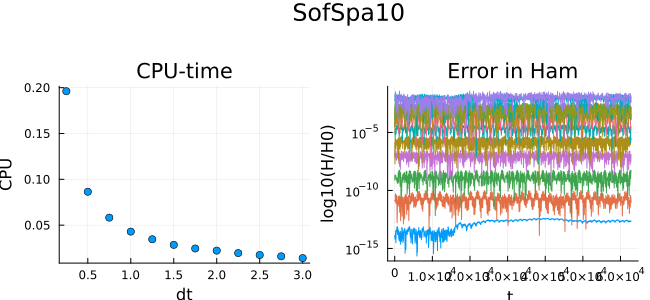

In [11]:
HAM=HenonHeliesHam
@show(HAM(u0))

#ddt0_sspa10=collect(1/8:1/8:2)
ddt0_sspa10=collect(1/4:1/4:3)

alg=SofSpa10()
sols_sspa10,retcodes_sspa10,cpus_sspa10,MaxΔHglobal_sspa10,MaxΔHlocal_sspa10=
run_many_2ndMethod(alg, ddt0_sspa10, tspan, u0, [0.], HAM);
fig=plots_2ndMethod("SofSpa10",ddt0_sspa10, u0, [0.], HAM,sols_sspa10,cpus_sspa10,MaxΔHlocal_sspa10)
display(fig)

In [12]:
[ddt0_sspa10 retcodes_sspa10  cpus_sspa10 MaxΔHglobal_sspa10 MaxΔHlocal_sspa10]

12×5 Matrix{Float64}:
 0.25  1.0  0.196125   4.23006e-13  6.52419e-14
 0.5   1.0  0.0864618  9.8501e-11   1.29143e-10
 0.75  1.0  0.0581898  5.76024e-9   1.08534e-8
 1.0   1.0  0.042949   2.96279e-7   2.46782e-7
 1.25  1.0  0.0345794  4.97628e-6   2.72524e-6
 1.5   1.0  0.0285144  5.0503e-5    1.89837e-5
 1.75  1.0  0.0245485  0.000318917  9.57784e-5
 2.0   1.0  0.0222126  0.000749817  0.000380125
 2.25  1.0  0.0195283  0.00390096   0.00125187
 2.5   1.0  0.0174604  0.0032747    0.00356512
 2.75  1.0  0.0160008  0.0206234    0.00909926
 3.0   1.0  0.0140529  0.0374338    0.0210184

<a href="#top">Back to the top</a>

## Benchmarks diagrams

### Work-precison diagrams

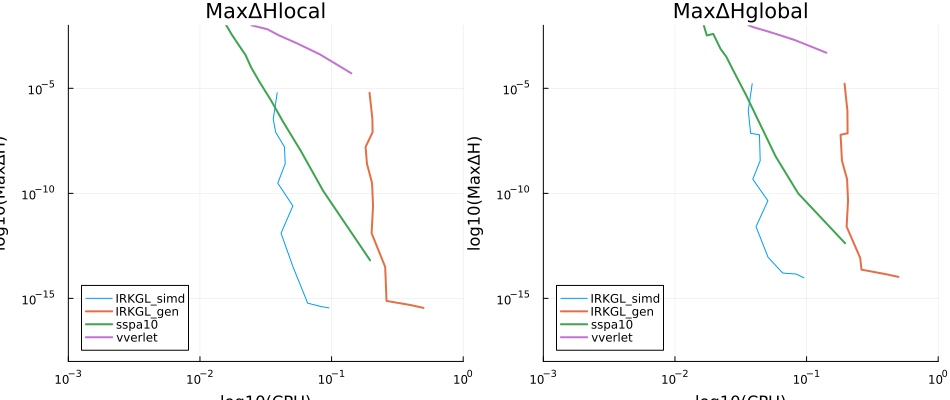

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict

In [13]:
yrange=(1e-18, 1e-2)
xrange=(1e-3,1e-0)
pl1=plot( cpus_simd , MaxΔHlocal_simd, scale=:log10,
         ylimits=yrange, xlimits=xrange,
         title="MaxΔHlocal", xlabel="log10(CPU)", ylabel="log10(MaxΔH)",
         label="IRKGL_simd", legend=:bottomleft)
plot!(pl1, cpus_gen , MaxΔHlocal_gen, lw=2,
      scale=:log10, xlabel="log10(CPU)", ylabel="log10(MaxΔH)", label="IRKGL_gen")
plot!(pl1, cpus_sspa10 , MaxΔHlocal_sspa10, lw=2,
      scale=:log10, xlabel="log10(CPU)", ylabel="log10(MaxΔH)", label="sspa10")
plot!(pl1, cpus_verlet , MaxΔHlocal_verlet, lw=2, 
      scale=:log10, xlabel="log10(CPU)", ylabel="log10(MaxΔH)", label="vverlet")

#
#
pl2=plot( cpus_simd , MaxΔHglobal_simd, scale=:log10, 
           ylimits=yrange, xlimits=xrange,
         title="MaxΔHglobal", xlabel="log10(CPU)", ylabel="log10(MaxΔH)",
         label="IRKGL_simd",  legend=:bottomleft)
plot!(pl2, cpus_gen , MaxΔHglobal_gen, lw=2,
           scale=:log10, xlabel="log10(CPU)", ylabel="log10(MaxΔH)", label="IRKGL_gen")
plot!(pl2, cpus_sspa10 , MaxΔHglobal_sspa10, lw=2, 
           scale=:log10, xlabel="log10(CPU)", ylabel="log10(MaxΔH)", label="sspa10")
plot!(pl2, cpus_verlet , MaxΔHglobal_verlet, lw=2,
           scale=:log10, xlabel="log10(CPU)", ylabel="log10(MaxΔH)", label="vverlet")


plot(pl1,pl2, layout=(1,2), size=(950,400)) #plot_title="", plot_titlevspan=0.2)

<a href="#top">Back to the top</a>

### Error in Energy (benchmark)

In [14]:
[ddt0 MaxΔHlocal_simd cpus_simd]

12×3 Matrix{Float64}:
 0.25  3.52383e-16  0.0955095
 0.5   4.09499e-16  0.0831459
 0.75  5.91807e-16  0.0658438
 1.0   3.13653e-14  0.0509663
 1.25  1.26389e-12  0.0413077
 1.5   2.5221e-11   0.0508115
 1.75  3.05756e-10  0.0390156
 2.0   2.56567e-9   0.0444288
 2.25  1.6192e-8    0.0438617
 2.5   8.15254e-8   0.0376009
 2.75  3.40396e-7   0.0360587
 3.0   6.09815e-6   0.0386164

In [15]:
[ddt0_sspa10  MaxΔHlocal_sspa10  cpus_sspa10 ]

12×3 Matrix{Float64}:
 0.25  6.52419e-14  0.196125
 0.5   1.29143e-10  0.0864618
 0.75  1.08534e-8   0.0581898
 1.0   2.46782e-7   0.042949
 1.25  2.72524e-6   0.0345794
 1.5   1.89837e-5   0.0285144
 1.75  9.57784e-5   0.0245485
 2.0   0.000380125  0.0222126
 2.25  0.00125187   0.0195283
 2.5   0.00356512   0.0174604
 2.75  0.00909926   0.0160008
 3.0   0.0210184    0.0140529

In [16]:
[ddt0_verlet  MaxΔHlocal_verlet  cpus_verlet ]

18×3 Matrix{Float64}:
 0.05  5.17037e-5   0.141405
 0.1   0.000413557  0.0814485
 0.15  0.0013956    0.0544575
 0.2   0.00330855   0.039829
 0.25  0.00646529   0.0325855
 0.3   0.0111834    0.0228695
 0.35  0.0177902    0.0191105
 0.4   0.0266237    0.0205912
 0.45  0.0380422    0.0142598
 0.5   0.0524087    0.01364
 0.55  0.0699448    0.0119619
 0.6   0.0914054    0.01128
 0.65  0.117591     0.0101274
 0.7   0.14861      0.00974164
 0.75  0.1856       0.00875968
 0.8   0.228653     0.00821468
 0.85  0.279096     0.00762465
 0.9   0.340368     0.00723237

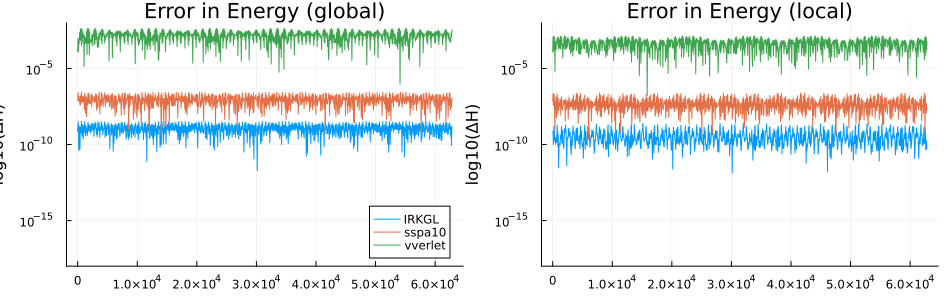

In [17]:
#
# IRKGL: h=1, index0=4 (exact solution)
# IRKGL: h=2, index1=8 
# sspa10: h=1., index2=4
# vverlet: h=0.15, index3=3

index0=4
index1=8
index2=4
index3=3

HAM=HenonHeliesHam
H0=HAM(u0_B)


H = [HAM(BigFloat.(u)) for u in sols_simd[index1].u]
ΔH0 = @. Float64(abs(H/H0-1))
ΔH0loc = @. Float64(abs((H[2:end] / H[1:end-1]) - 1))

m0 = max(1,div(Int64(ceil((tF-t0)/ddt0[index1])),1000))

yrange=(1e-18,1e-2)
pl3=plot(sols_simd[index1].t[2:m0:end], abs.(ΔH0[2:m0:end]),
        ylimits=yrange,
        xlabel="t", ylabel="log10(ΔH)",title="Error in Energy (global)",
        yscale=:log10, label="IRKGL", legend=:bottomright)

pl4=plot(sols_simd[index1].t[2:m0:end], abs.(ΔH0loc[1:m0:end]),
        ylimits=yrange,
        xlabel="t", ylabel="log10(ΔH)",title="Error in Energy (local)",
        yscale=:log10, label="")

# sspa10

T=typeof(u0)
solu_sspa10=Array{T}(undef,length(sols_sspa10[index2].u))     
for k in 1:length(solu_sspa10)
    solu_sspa10[k]=zero(u0)
    solu_sspa10[k][1:2].=sols_sspa10[index2].u[k].x[2]
    solu_sspa10[k][3:4].=sols_sspa10[index2].u[k].x[1]
end

m0 = max(1,div(Int64(ceil((tF-t0)/ddt0_sspa10[index2])),1000))      
H = [HAM(BigFloat.(u)) for u in solu_sspa10]
ΔH0 = @. Float64(abs(H/H0-1))
ΔH0loc = @. Float64(abs((H[2:end] / H[1:end-1]) - 1))

plot!(pl3, sols_sspa10[index2].t[2:m0:end], abs.(ΔH0[2:m0:end]), yscale=:log10, label="sspa10")
plot!(pl4, sols_sspa10[index2].t[2:m0:end], abs.(ΔH0loc[1:m0:end]), yscale=:log10, label="")

# vverlet
T=typeof(u0)
solu_vverlet=Array{T}(undef,length(sols_verlet[index3].u))
for k in 1:length(solu_vverlet)
    solu_vverlet[k]=zero(u0)
    solu_vverlet[k][1:2].=sols_verlet[index3].u[k].x[2]
    solu_vverlet[k][3:4].=sols_verlet[index3].u[k].x[1]
end
m0 = max(1,div(Int64(ceil((tF-t0)/ddt0_verlet[index3])),1000))
H = [HAM(BigFloat.(u)) for u in solu_vverlet]
ΔH0 = @. Float64(abs(H/H0-1))
ΔH0loc = @. Float64(abs((H[2:end] / H[1:end-1]) - 1))

plot!(pl3, sols_verlet[index3].t[2:m0:end], abs.(ΔH0[2:m0:end]), yscale=:log10,label="vverlet")
plot!(pl4, sols_verlet[index3].t[2:m0:end], abs.(ΔH0loc[1:m0:end]), yscale=:log10, label="")

fig=plot(pl3,pl4, layout=(1,2), size=(950,300)) #, plot_title=title, plot_titlevspan=0.2)

<a href="#top">Back to the top</a>

### Error in Solution (benchmark)

In [18]:
[sols_simd[index0].t[7] sols_simd[index1].t[4] sols_sspa10[index2].t[7] sols_verlet[index3].t[41]]

1×4 Matrix{Float64}:
 6.0  6.0  6.0  6.0

In [19]:
[sols_simd[index0].t[7:6:3*7]  sols_simd[index1].t[4:3:3*4] sols_sspa10[index2].t[7:6:3*7] sols_verlet[index3].t[41:40:3*41]]

3×4 Matrix{Float64}:
  6.0   6.0   6.0   6.0
 12.0  12.0  12.0  12.0
 18.0  18.0  18.0  18.0

In [20]:
i0=7
i1=4
i2=7
i3=41


error_irkgl_q1=map((u,u1)->abs(BigFloat(u[1])/BigFloat(u1[1])-1), sols_simd[index1].u[i1:i1-1:end], sols_simd[index0].u[i0:i0-1:end])
error_irkgl_q2=map((u,u1)->abs(BigFloat(u[2])/BigFloat(u1[2])-1), sols_simd[index1].u[i1:i1-1:end], sols_simd[index0].u[i0:i0-1:end])
error_irkgl_p1=map((u,u1)->abs(BigFloat(u[3])/BigFloat(u1[3])-1), sols_simd[index1].u[i1:i1-1:end], sols_simd[index0].u[i0:i0-1:end])
error_irkgl_p2=map((u,u1)->abs(BigFloat(u[4])/BigFloat(u1[4])-1), sols_simd[index1].u[i1:i1-1:end], sols_simd[index0].u[i0:i0-1:end])

error_sspa10_q1=map((u,u1)->abs(BigFloat(u[1])/BigFloat(u1[1])-1), solu_sspa10[i2:i2-1:end], sols_simd[index0].u[i0:i0-1:end])
error_sspa10_q2=map((u,u1)->abs(BigFloat(u[2])/BigFloat(u1[2])-1), solu_sspa10[i2:i2-1:end], sols_simd[index0].u[i0:i0-1:end])
error_sspa10_p1=map((u,u1)->abs(BigFloat(u[3])/BigFloat(u1[3])-1), solu_sspa10[i2:i2-1:end], sols_simd[index0].u[i0:i0-1:end])
error_sspa10_p2=map((u,u1)->abs(BigFloat(u[4])/BigFloat(u1[4])-1), solu_sspa10[i2:i2-1:end], sols_simd[index0].u[i0:i0-1:end])

error_vverlet_q1=map((u,u1)->abs(BigFloat(u[1])/BigFloat(u1[1])-1), solu_vverlet[i3:i3-1:end], sols_simd[index0].u[i0:i0-1:end])
error_vverlet_q2=map((u,u1)->abs(BigFloat(u[2])/BigFloat(u1[2])-1), solu_vverlet[i3:i3-1:end], sols_simd[index0].u[i0:i0-1:end])
error_vverlet_p1=map((u,u1)->abs(BigFloat(u[3])/BigFloat(u1[3])-1), solu_vverlet[i3:i3-1:end], sols_simd[index0].u[i0:i0-1:end])
error_vverlet_p2=map((u,u1)->abs(BigFloat(u[4])/BigFloat(u1[4])-1), solu_vverlet[i3:i3-1:end], sols_simd[index0].u[i0:i0-1:end]);



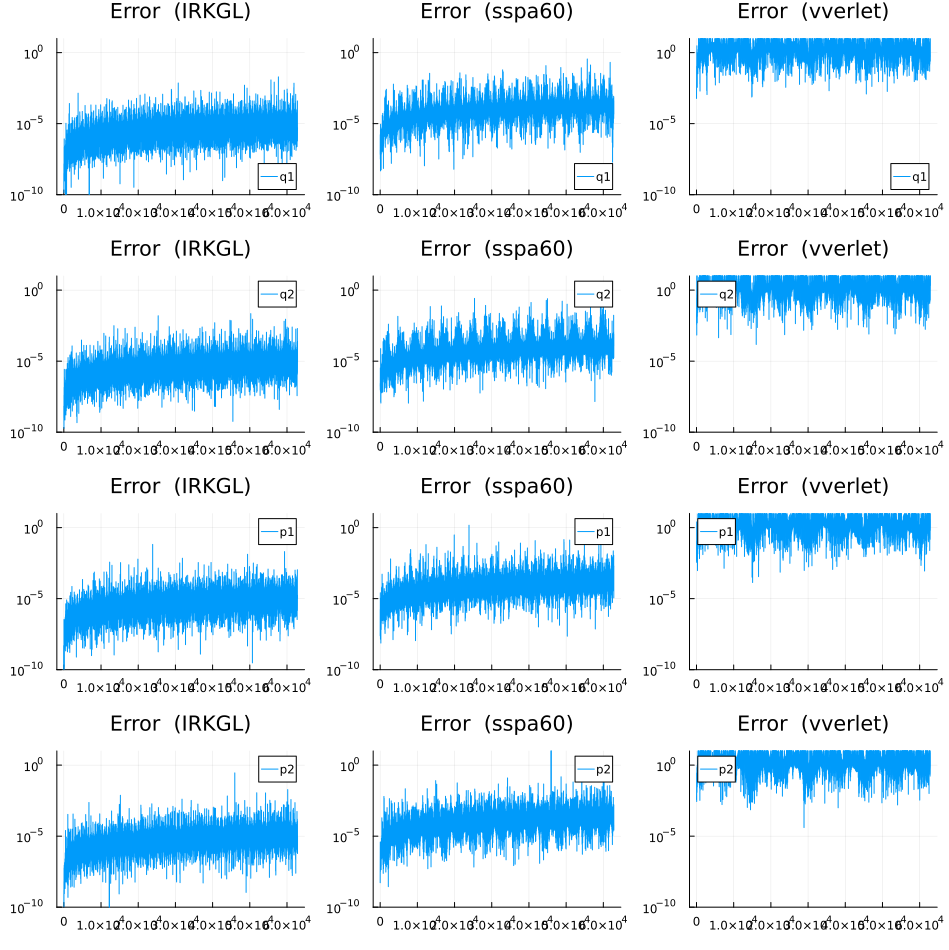

In [21]:
yrange=(1e-10, 1e1)

# IRKGL

pe11=plot(sols_simd[index1].t[i1:i1-1:end], error_irkgl_q1,
         title="Error  (IRKGL)",
         ylims=yrange,
         yscale=:log10, legend=:bottomright,
         xlabel="",ylabel="", label="q1")

pe12=plot(sols_simd[index1].t[i1:i1-1:end], error_irkgl_q2,
         title="Error  (IRKGL)",
         ylims=yrange,
         yscale=:log10,
         xlabel="",ylabel="", label="q2")

pe13=plot(sols_simd[index1].t[i1:i1-1:end], error_irkgl_p1,
         title="Error  (IRKGL)",
         ylims=yrange,
         yscale=:log10,
         xlabel="",ylabel="", label="p1")

pe14=plot(sols_simd[index1].t[i1:i1-1:end], error_irkgl_p2,
         title="Error  (IRKGL)",
         ylims=yrange,
         yscale=:log10,
         xlabel="",ylabel="", label="p2")

# sspa60

pe21=plot(sols_sspa10[index2].t[i2:i2-1:end], error_sspa10_q1,
         title="Error  (sspa60)",
         ylims=yrange,
         yscale=:log10, legend=:bottomright,
         xlabel="",ylabel="", label="q1")

pe22=plot(sols_sspa10[index2].t[i2:i2-1:end], error_sspa10_q2,
         title="Error  (sspa60)",
         ylims=yrange,
         yscale=:log10,
         xlabel="",ylabel="", label="q2")

pe23=plot(sols_sspa10[index2].t[i2:i2-1:end], error_sspa10_p1,
         title="Error  (sspa60)",
         ylims=yrange,
         yscale=:log10,
         xlabel="",ylabel="", label="p1")

pe24=plot(sols_sspa10[index2].t[i2:i2-1:end], error_sspa10_p2,
         title="Error  (sspa60)",
         ylims=yrange,
         yscale=:log10,
         xlabel="",ylabel="", label="p2")

# vverlet

pe31=plot(sols_verlet[index3].t[i3:i3-1:end], error_vverlet_q1,
         title="Error  (vverlet)",
         ylims=yrange,
         yscale=:log10, legend=:bottomright,
         xlabel="",ylabel="", label="q1")

pe32=plot(sols_verlet[index3].t[i3:i3-1:end], error_vverlet_q2,
         title="Error  (vverlet)",
         ylims=yrange,
         yscale=:log10,
         xlabel="",ylabel="", label="q2")

pe33=plot(sols_verlet[index3].t[i3:i3-1:end], error_vverlet_p1,
         title="Error  (vverlet)",
         ylims=yrange,
         yscale=:log10,
         xlabel="",ylabel="", label="p1")

pe34=plot(sols_verlet[index3].t[i3:i3-1:end], error_vverlet_p2,
         title="Error  (vverlet)",
         ylims=yrange,
         yscale=:log10,
         xlabel="",ylabel="", label="p2")

plot(pe11,pe21,pe31, 
     pe12,pe22,pe32,
     pe13,pe23,pe33,
     pe14,pe24,pe34, 
     layout=(4,3), size=(950,950))